# IEOR 242 Assignment 07
Correlation between positive words and company performance

In [1]:
import pandas as pd
import numpy as np
from scipy.stats.stats import pearsonr
import pickle
import nltk
from sklearn import linear_model
from sklearn.cross_validation import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid")

In [2]:
import pymysql
from sqlalchemy import create_engine

# Connect to team database
engine = create_engine('mysql+pymysql://<user>:<password>@<host>[:<port>]/<dbname>')

In [3]:
# Path to the Loughran McDonald dictionary
MASTER_DICT_PATH = '../lecture/LoughranMcDonald_MasterDictionary_2014.xlsx'

## Data Loading
Read the dataframe with file contents and labels from a Pickle file.

In [4]:
with open('prepared_class2.pickle', 'rb') as f:
    class_df = pickle.load(f)

print('Number of reports: %d' % len(class_df))
class_df.head()

Number of reports: 12504


,content,OIADP,AT,CEQ,SALES,OIADP_change,AT_change,CEQ_change,SALES_change
0,Item7.Management's Discussion and Analysis of ...,pos,neg,neg,neg,19.30809539,-5.710814,-16.88298821,-9.225092251
1,The following discussion and analysis provide...,neg,pos,pos,neg,-14.5187602,14.640276,11.23801315,-1.89063409
2,Item 7.\nManagements Discussion and Analysis o...,neg,pos,pos,neg,-22.56208359,0.525303,2.764397345,-11.54303553
3,-----BEGIN PRIVACY-ENHANCED MESSAGE-----\nProc...,neg,neg,pos,neg,-814.6341463,-56.183942,15.27777778,-65.41343833
4,Item 7. Management's Discussion and Analy...,pos,neg,neg,neg,328.5234899,-1.733328,-5.815035355,-39.56639566


In [5]:
# Reduce data set for faster development
class_df = class_df.sample(frac=0.5)

## Extract Positive Words from Dictionary

In [6]:
# Load the dictionary
dict = pd.read_excel(MASTER_DICT_PATH)
print('Number of words in the dictionary: %d' % len(dict))
dict.head()

Number of words in the dictionary: 85131


,Word,Sequence Number,Word Count,Word Proportion,Average Proportion,Std Dev,Doc Count,Negative,Positive,Uncertainty,Litigious,Constraining,Superfluous,Interesting,Modal,Irr_Verb,Harvard_IV,Syllables,Source
0,AARDVARK,1,81,5.690194e-09,3.068740e-09,5.779943e-07,45,0,0,0,0,0,0,0,0,0,0,2,12of12inf
1,AARDVARKS,2,2,1.404986e-10,8.217606e-12,7.841870e-09,1,0,0,0,0,0,0,0,0,0,0,2,12of12inf
2,ABACI,3,8,5.619945e-10,1.686149e-10,7.096240e-08,7,0,0,0,0,0,0,0,0,0,0,3,12of12inf
3,ABACK,4,5,3.512466e-10,1.727985e-10,7.532677e-08,5,0,0,0,0,0,0,0,0,0,0,2,12of12inf
4,ABACUS,5,1752,1.230768e-07,1.198634e-07,1.110293e-05,465,0,0,0,0,0,0,0,0,0,0,3,12of12inf


In [7]:
# Extract list with all positive words
positive_words = list(map(lambda w: w.lower(), dict.loc[dict['Positive'] > 0, 'Word'].tolist()))
print('Number of positive words: %d' % len(positive_words))
positive_words[:5]

Number of positive words: 354


['able', 'abundance', 'abundant', 'acclaimed', 'accomplish']

## Feature Building

In [8]:
# Create the tokenizer module which also removes symbols
tokenizer = nltk.RegexpTokenizer(r'\w+')

In [11]:
# Tokenize the lower-case text and find the percentage of positive tokens
def count_pos_tokens(text):
    tokens = tokenizer.tokenize(text.lower())
    pos_tokens = [t for t in tokens if t in positive_words]
    if len(tokens) > 0:
        return (len(pos_tokens) / len(tokens))
    else:
        return 0

In [12]:
# Calculate percentage of positive tokens for all reports
class_df['pos_token_perc'] = class_df['content'].map(lambda c: count_pos_tokens(c))
print('Size of class_df: %d' % len(class_df))
class_df.head()

Size of class_df: 6252


,content,OIADP,AT,CEQ,SALES,OIADP_change,AT_change,CEQ_change,SALES_change,pos_token_perc
1691,-----BEGIN PRIVACY-ENHANCED MESSAGE-----\nProc...,pos,pos,pos,pos,16.04529136,3.388475,1.205573169,9.279300023,0.004175
182,Managements Discussion and Analysis of Financ...,neg,pos,pos,pos,-235.9391965,120.649461,11.95116755,28.59973954,0.005760
8860,-----BEGIN PRIVACY-ENHANCED MESSAGE-----\nProc...,pos,pos,pos,pos,7.509182424,5.826997,2.474536312,8.24492409,0.006579
5251,ITEM 7. MANAGEMENT'S DISCUSSION AND ANALYSIS ...,neg,neg,neg,pos,-11.5497076,-0.287962,-2.811982489,13.1627926,0.006422
12410,ITEM\n7. MANAGEMENTS DISCUSSION AND ANALYSIS O...,pos,neg,neg,pos,21.1338477,-1.597870,-85.07328072,20.10339734,0.010818


## Linear Regression
scikit-learn linear regression: http://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html

In [35]:
# Prepare data set by removing non-numeric values
reg_df = class_df[['pos_token_perc', 'OIADP_change', 'AT_change', 'CEQ_change',
                   'SALES_change']].apply(pd.to_numeric, errors='coerce').dropna()
print('Size of reg_df: %d' % len(reg_df))

# Remove outliers from the data set
TRESHOLD = 100
reg_df = reg_df[(reg_df['SALES_change'] < TRESHOLD) & \
                (reg_df['SALES_change'] > -TRESHOLD) & \
                (reg_df['OIADP_change'] < TRESHOLD) & \
                (reg_df['OIADP_change'] > -TRESHOLD) & \
                (reg_df['AT_change'] < TRESHOLD) & \
                (reg_df['AT_change'] > -TRESHOLD) & \
                (reg_df['CEQ_change'] < TRESHOLD) & \
                (reg_df['CEQ_change'] > -TRESHOLD) & \
                (reg_df['pos_token_perc'] < 0.1) & \
                (reg_df['pos_token_perc'] > 0)]
print('Size of filtered reg_df: %d' % len(reg_df))

reg_df.head()

Size of reg_df: 5343
Size of filtered reg_df: 3793


,pos_token_perc,OIADP_change,AT_change,CEQ_change,SALES_change
1691,0.004175,16.045291,3.388475,1.205573,9.279300
8860,0.006579,7.509182,5.826997,2.474536,8.244924
5251,0.006422,-11.549708,-0.287962,-2.811982,13.162793
12410,0.010818,21.133848,-1.597870,-85.073281,20.103397
11923,0.007417,5.875681,0.669243,-1.025787,4.653743


In [36]:
# Calculate correlation
print('Pearson correlation with OIADP change: %f' % pearsonr(reg_df['pos_token_perc'], reg_df['OIADP_change'])[0])
print('Pearson correlation with AT change: %f' % pearsonr(reg_df['pos_token_perc'], reg_df['AT_change'])[0])
print('Pearson correlation with CEQ change: %f' % pearsonr(reg_df['pos_token_perc'], reg_df['CEQ_change'])[0])
print('Pearson correlation with SALES change: %f' % pearsonr(reg_df['pos_token_perc'], reg_df['SALES_change'])[0])

Pearson correlation with OIADP change: 0.013468
Pearson correlation with AT change: 0.000088
Pearson correlation with CEQ change: -0.054762
Pearson correlation with SALES change: -0.011583


In [37]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = \
    train_test_split(reg_df[['OIADP_change', 'AT_change', 'CEQ_change', 'SALES_change']],
                     reg_df['pos_token_perc'], test_size=0.3, random_state=123)
print('Size X_train: %d' % len(X_train))
print('Size X_test: %d' % len(X_test))
print('Size y_train: %d' % len(y_train))
print('Size y_test: %d' % len(y_test))

Size X_train: 2655
Size X_test: 1138
Size y_train: 2655
Size y_test: 1138


In [38]:
# Create linear regression object
regr = linear_model.LinearRegression()

In [39]:
# Train the model using the training sets
regr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [40]:
# Print model results
print('Intercept: ', regr.intercept_)
print('Coefficients: ', regr.coef_)
print('Mean square error: %f' % np.mean((regr.predict(X_test) - y_test) ** 2))
print('Variance score (R^2): %f' % regr.score(X_test, y_test))

Intercept:  0.00657461777149
Coefficients:  [  1.61159800e-06  -4.04084419e-06  -4.21230512e-06   4.04096589e-07]
Mean square error: 0.000008
Variance score (R^2): -0.000626


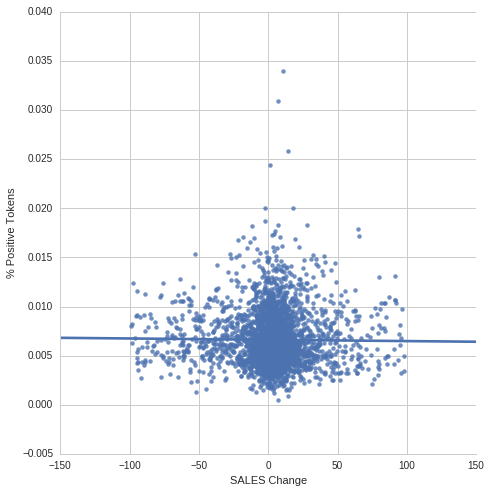

In [41]:
# Regression plot of SALES_change ans pos_token_perc
g = sns.lmplot(x='SALES_change', y='pos_token_perc', data=reg_df, size=7, ci=None)
g.set_axis_labels('SALES Change', '% Positive Tokens')